In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(93)

### *Structural Causal Model*
$X_{4}=2\epsilon_{4}+1$
<br>
$X_{6}=\epsilon_{6}-1$
<br>
$X_{5}=3X_{6}+\epsilon_{5}-1$
<br>
$X_{2}=X_{5}-\epsilon_{2}$
<br>
$X_{3}=-3X_{4}+\epsilon_{3}-3$
<br>
$X_{1}=X_{6}-X_{5}+3\epsilon_{1}$
<br>
$Y=X_{1}+2X_{2}-3X_{3}+\epsilon_{Y}$


In [2]:
sample_size=1000
epsilon=np.random.normal(0,1,(sample_size,7))

In [3]:
def SCM(intervention=False,*args):
    X_4=2*epsilon[:,4]+1
    X_6=epsilon[:,6]-1
    if not intervention:
        X_5=3*X_6+epsilon[:,5]-1
    else:
        X_5=np.full(sample_size,args)
    X_2=X_5-epsilon[:,2]
    X_3=-3*X_4+epsilon[:,3]-3
    X_1=X_6-X_5+3*epsilon[:,1]
    Y=X_1+2*X_2-3*X_3+epsilon[:,0]
    return X_6,X_5,X_4,X_3,X_2,X_1,Y

In [4]:
X_6,X_5,X_4,X_3,X_2,X_1,Y= SCM(False)

### *Preprocessing the data*
---

In [5]:
import os
import re
import glob
import time
import torch
import numpy as np
import pandas as pd
import scipy.misc as m
from torch.utils import data
from math import isnan, isinf



class featuresDataset(data.Dataset):

    def __init__(self,dim = 1,
        inference = False, train = True,
        train_ratio = 0.8,
        #random_seed = 67,
    ):
        super(featuresDataset, self).__init__()
        self.dim = dim
        self.random_seed =   69 #random_seed
        self.inference = inference

        self.data, self.y = [], []
        print('==> started preprocessing data ...')
        for index in range(sample_size):
            self.data.append(dict(
                X6 =  np.asarray(X_6[index]).astype(np.float32),
                X5 =  np.asarray(X_5[index]).astype(np.float32),
                X4 =  np.asarray(X_4[index]).astype(np.float32),
                X3 =  np.asarray(X_3[index]).astype(np.float32),
                X2 =  np.asarray(X_2[index]).astype(np.float32),
                X1 =  np.asarray(X_1[index]).astype(np.float32),
                Y  =  np.asarray(Y[index]).astype(np.float32), 
                sample_id= index
            ))
        print('==> finished preprocessing data ...')

        if not self.inference:                                                      #when inference is flase 
            self.ids = np.arange(0, len(self.data))           #img_idxes --> ids
            np.random.seed(self.random_seed)
            np.random.shuffle(self.ids)
            last_train_sample = int(len(self.ids) * train_ratio)
            if train:                                                               #when training is true
                self.ids = self.ids[:last_train_sample]
            else:
                self.ids = self.ids[last_train_sample:]
        else:                                                                       #when inference is true
            self.ids = np.arange(0, len(self.data))


    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id_ = self.ids[index]
        info = self.data[id_]
        
        id= info['sample_id']
        X6 = torch.from_numpy(info['X6'])
        X5 = torch.from_numpy(info['X5'])
        X4 = torch.from_numpy(info['X4'])
        X3 = torch.from_numpy(info['X3'])
        X2 = torch.from_numpy(info['X2'])
        X1 = torch.from_numpy(info['X1'])
        Y = torch.from_numpy(info['Y'])
        #X4 = torch.tensor().float()
        #age = torch.tensor(info['age']).unsqueeze(-1).float()
        

        if self.inference:
            return X6, X5, X4,  X3, X2,  X1, Y, id
        else:
            return X6, X5, X4,  X3, X2,  X1, Y


def get_features_dataset(
    dim=1,
    inference=False,
    train_ratio=0.8,
    #random_seed=67,
    ):

    if not inference:
        dataset_train = featuresDataset(train=True, dim=dim,
            train_ratio=train_ratio) #random_seed=random_seed)
        dataset_test = featuresDataset(train=False,  dim=dim,
            train_ratio=train_ratio) #random_seed=random_seed)

        return dataset_train, dataset_test
    else:
        dataset = featuresDataset(inference=True,  dim=dim,
            train_ratio=train_ratio) #random_seed=random_seed)

        return dataset

### *Flow-based SCMs*

In [6]:
import pyro
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Independent
from pyro.infer.reparam.transform import TransformReparam
from pyro.distributions.torch_transform import ComposeTransformModule
from pyro.nn import PyroModule, pyro_method
from pyro.distributions import Normal,TransformedDistribution
from pyro.distributions.transforms import Spline, AffineTransform, ExpTransform, ComposeTransform, spline_coupling 
from pyro.distributions.transforms import conditional_spline
from pyro.distributions.conditional import ConditionalTransformedDistribution

### Full Model

In [7]:
#full model

class ConditionalSCM(PyroModule):
    def __init__(self,context_dim=2,normalize=True,spline_bins=8,spline_order='linear'):
        super(ConditionalSCM, self).__init__()
        self.context_dim = context_dim
        self.spline_bins = spline_bins
        self.spline_order = spline_order
        self.normalize = normalize
        

        
        #Flows ---------------------------------------------------------------------------------------------
        
        # X_4 flows
        self.X4_flow_component = Spline(1, count_bins=self.spline_bins)
        self.X4_flow_transforms = ComposeTransform([self.X4_flow_component])
        
        # X_6 flows
        self.X6_flow_component = Spline(1, count_bins=self.spline_bins)
        self.X6_flow_transforms = ComposeTransform([self.X6_flow_component])
        
        #X_5 flows
        self.X5_flow_component = conditional_spline(1, context_dim=1, count_bins=self.spline_bins, order=self.spline_order)
        self.X5_flow_transforms = ComposeTransformModule([self.X5_flow_component])
        
        #X_2 flows 
        self.X2_flow_component = conditional_spline(1, context_dim=1, count_bins=self.spline_bins, order=self.spline_order)
        self.X2_flow_transforms = ComposeTransformModule([self.X2_flow_component])
        
        #X_3 flows 
        self.X3_flow_component = conditional_spline(1, context_dim=1, count_bins=self.spline_bins, order=self.spline_order)
        self.X3_flow_transforms = ComposeTransformModule([self.X3_flow_component])
        
        
        #X_1 flows 
        self.X1_flow_component = conditional_spline(1, context_dim=2, count_bins=self.spline_bins, order=self.spline_order)
        self.X1_flow_transforms = ComposeTransformModule([self.X1_flow_component])
        
        #Y flows
        self.Y_flow_component = conditional_spline(1, context_dim=3, count_bins=self.spline_bins, order=self.spline_order)
        self.Y_flow_transforms = ComposeTransformModule([self.Y_flow_component])
        
       

            
    def pgm_model(self):
        loc=torch.tensor([0.0])
        scale=torch.tensor([1.0])
        # X4
        self.X4_base_dist = Normal(loc,scale).to_event(1)
        self.X4_dist=TransformedDistribution(self.X4_base_dist, self.X4_flow_transforms)
        self.X4 = pyro.sample('X4', self.X4_dist,)
        # X6
        self.X6_base_dist = Normal(loc,scale).to_event(1)
        self.X6_dist=TransformedDistribution(self.X6_base_dist, self.X6_flow_transforms)
        self.X6 = pyro.sample('X6', self.X6_dist,)
        #X5
        context_X5=torch.cat([self.X6],-1)
        self.X5_base_dist = Normal(loc,scale).to_event(1)
        self.X5_dist = ConditionalTransformedDistribution(self.X5_base_dist, self.X5_flow_transforms).condition(context_X5)
        self.X5 = pyro.sample('X5', self.X5_dist)
        #X3
        context_X3=torch.cat([self.X4],-1)
        self.X3_base_dist = Normal(loc,scale).to_event(1)
        self.X3_dist = ConditionalTransformedDistribution(self.X3_base_dist, self.X3_flow_transforms).condition(context_X3)
        self.X3 = pyro.sample('X3', self.X3_dist)
        #X2
        context_X2=torch.cat([self.X5],-1)
        self.X2_base_dist = Normal(loc,scale).to_event(1)
        self.X2_dist = ConditionalTransformedDistribution(self.X2_base_dist, self.X2_flow_transforms).condition(context_X2)
        self.X2 = pyro.sample('X2', self.X2_dist)
        #X1
        context_X1=torch.cat([self.X5,self.X6],-1)
        self.X1_base_dist = Normal(loc,scale).to_event(1)
        self.X1_dist = ConditionalTransformedDistribution(self.X1_base_dist, self.X1_flow_transforms).condition(context_X1)
        self.X1 = pyro.sample('X1', self.X1_dist)
        # Y
        context_Y=torch.cat([self.X3,self.X2,self.X1],-1)
        self.Y_base_dist = Normal(loc,scale).to_event(1)
        self.Y_dist = ConditionalTransformedDistribution(self.Y_base_dist, self.Y_flow_transforms).condition(context_Y)
        self.Y = pyro.sample('Y', self.Y_dist)
       
        
        

    def forward(self, X6,X5, X4,X3,X2,X1,Y ):
        self.pgm_model()
        X6_logp = self.X6_dist.log_prob(X6)
        X5_logp = self.X5_dist.log_prob(X5)
        X4_logp = self.X4_dist.log_prob(X4)
        X3_logp = self.X3_dist.log_prob(X3)
        X2_logp = self.X2_dist.log_prob(X2)
        X1_logp = self.X1_dist.log_prob(X1)
        Y_logp = self.Y_dist.log_prob(Y)
        return {'X_6':X6_logp,'X_5':X5_logp,'X_4': X4_logp, 'X_3': X3_logp, 'X_2': X2_logp, 'X_1': X1_logp,'Y': Y_logp}

    def clear(self):
        self.X5_dist.clear_cache()
        self.X3_dist.clear_cache()
        self.X2_dist.clear_cache()
        self.X1_dist.clear_cache()
        self.Y_dist.clear_cache()
        
    def model(self):
        self.pgm_model()
        return self.X6, self.X5, self.X4, self.X3, self.X2, self.X1, self.Y

    def scm(self, *args, **kwargs):
        def config(msg):
            if isinstance(msg['fn'], TransformedDistribution):
                return TransformReparam()
            else:
                return None
        return pyro.poutine.reparam(self.model, config=config)(*args, **kwargs)

    def sample(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.model()
        return (*samples,)

    def sample_scm(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.scm()
        return (*samples,)
    
    def infer_exogeneous(self, **obs):
        cond_sample = pyro.condition(self.sample, data=obs)
        cond_trace = pyro.poutine.trace(cond_sample).get_trace(obs['X1'].shape[0])
        output = {}
        for name, node in cond_trace.nodes.items():
            if 'fn' not in node.keys():
                continue
            fn = node['fn']
            if isinstance(fn, Independent):
                fn = fn.base_dist

            if isinstance(fn, TransformedDistribution):
                output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])
        return output

    def counterfactual(self, obs,intervention, num_particles=1):
        counterfactuals = []

        for _ in range(num_particles):
            exogeneous = self.infer_exogeneous(**obs)
            condition= {intervention.split('=')[0].split('(')[-1] :torch.full_like( obs['X4'],float(intervention.split('=')[-1][:-1]))}
            counter = pyro.poutine.do(pyro.poutine.condition(self.sample_scm, data=exogeneous), data=condition)(obs['X1'].shape[0])
            counterfactuals += [counter]
            #print('helper',helper)
            #print('helper',helper)

        return {k: v for k, v in zip(('X_6','X_5','X_4', 'X_3', 'X_2', 'X_1','Y'), (torch.stack(c).mean(0) for c in zip(*counterfactuals)))}


def conditionalscm():
    model = ConditionalSCM(context_dim=2,normalize=True,spline_bins=8,spline_order='linear')
    return model


In [8]:
scm=conditionalscm()
#print(scm.sample(n_samples=2))

In [9]:
data = {'X6': torch.rand(1).reshape(-1,1),
        'X5': torch.rand(1).reshape(-1,1),
        'X4': torch.rand(1).reshape(-1,1), 
        'X3': torch.rand(1).reshape(-1,1), 
        'X2': torch.rand(1).reshape(-1,1),
        'X1': torch.rand(1).reshape(-1,1),
        'Y': torch.rand(1).reshape(-1,1)} 
print(data)
data2 = {'X6': torch.rand(2).reshape(-1,1),
        'X5': torch.rand(2).reshape(-1,1),
        'X4': torch.rand(2).reshape(-1,1), 
        'X3': torch.rand(2).reshape(-1,1), 
        'X2': torch.rand(2).reshape(-1,1),
        'X1': torch.rand(2).reshape(-1,1),
        'Y': torch.rand(2).reshape(-1,1)} 
print(data2)

{'X6': tensor([[0.3960]]), 'X5': tensor([[0.1405]]), 'X4': tensor([[0.2559]]), 'X3': tensor([[0.3896]]), 'X2': tensor([[0.1750]]), 'X1': tensor([[0.3916]]), 'Y': tensor([[0.2014]])}
{'X6': tensor([[0.6554],
        [0.0393]]), 'X5': tensor([[0.4132],
        [0.8467]]), 'X4': tensor([[0.8286],
        [0.4782]]), 'X3': tensor([[0.8200],
        [0.5977]]), 'X2': tensor([[0.7620],
        [0.7924]]), 'X1': tensor([[0.8985],
        [0.5049]]), 'Y': tensor([[0.4255],
        [0.1001]])}


Note that, in the full model, we infer state of all $\epsilon_{i}$'s

In [10]:
print(scm.infer_exogeneous(**data))
exogeneous=scm.infer_exogeneous(**data)
#print(scm.infer_exogeneous(**data2))
#exogeneous=scm.infer_exogeneous(**data2)


{'X4_base': tensor([[-2.5118]], grad_fn=<IndexPutBackward0>), 'X6_base': tensor([[-0.9081]], grad_fn=<IndexPutBackward0>), 'X5_base': tensor([[-0.3090]], grad_fn=<IndexPutBackward0>), 'X3_base': tensor([[0.2725]], grad_fn=<IndexPutBackward0>), 'X2_base': tensor([[0.1922]], grad_fn=<IndexPutBackward0>), 'X1_base': tensor([[0.2638]], grad_fn=<IndexPutBackward0>), 'Y_base': tensor([[0.4540]], grad_fn=<IndexPutBackward0>)}


In [11]:
intervention='do(X5=0.7)'
print(scm.counterfactual(obs=data2,intervention=intervention))

{'X_6': tensor([[0.6554],
        [0.0393]]), 'X_5': tensor([[0.7000],
        [0.7000]]), 'X_4': tensor([[0.8286],
        [0.4782]]), 'X_3': tensor([[0.8200],
        [0.5977]], grad_fn=<MeanBackward1>), 'X_2': tensor([[0.7921],
        [0.7784]], grad_fn=<MeanBackward1>), 'X_1': tensor([[0.9125],
        [0.5007]], grad_fn=<MeanBackward1>), 'Y': tensor([[0.4209],
        [0.1021]], grad_fn=<MeanBackward1>)}


### Partial model

In [12]:
#partial model

class ConditionalSCM_partial(PyroModule):
    def __init__(self,context_dim=2,normalize=True,spline_bins=8,spline_order='linear'):
        super(ConditionalSCM_partial, self).__init__()
        self.context_dim = context_dim
        self.spline_bins = spline_bins
        self.spline_order = spline_order
        self.normalize = normalize
        

        
        #Flows ---------------------------------------------------------------------------------------------
        
        # X_4 flows
        #self.X4_flow_component = Spline(1, count_bins=self.spline_bins)
        #self.X4_flow_transforms = ComposeTransform([self.X4_flow_component])
        
        # X_3 flows
        #self.X3_flow_component = Spline(1, count_bins=self.spline_bins)
        #self.X3_flow_transforms = ComposeTransform([self.X3_flow_component])
        
        #X_2 flows 
        self.X2_flow_component = conditional_spline(1, context_dim=1, count_bins=self.spline_bins, order=self.spline_order)
        self.X2_flow_transforms = ComposeTransformModule([self.X2_flow_component])
        
        #X_1 flows 
        self.X1_flow_component = conditional_spline(1, context_dim=2, count_bins=self.spline_bins, order=self.spline_order)
        self.X1_flow_transforms = ComposeTransformModule([self.X1_flow_component])
        
        #Y flows
        self.Y_flow_component = conditional_spline(1, context_dim=3, count_bins=self.spline_bins, order=self.spline_order)
        self.Y_flow_transforms = ComposeTransformModule([self.Y_flow_component])
        
       

            
    def pgm_model(self):
        loc=torch.tensor([0.0])
        scale=torch.tensor([1.0])
         # X4
        self.X4_dist = Normal(loc,scale).to_event(1)
        #self.X4_dist=TransformedDistribution(self.X4_base_dist, self.X4_flow_transforms)
        self.X4 = pyro.sample('X4', self.X4_dist,)
        # X6
        self.X6_dist = Normal(loc,scale).to_event(1)
        #self.X6_dist=TransformedDistribution(self.X6_base_dist, self.X6_flow_transforms)
        self.X6 = pyro.sample('X6', self.X6_dist,)
        #X5
        #context_X5=torch.cat([self.X6],-1)
        self.X5_dist = Normal(loc,scale).to_event(1)
        #self.X5_dist = ConditionalTransformedDistribution(self.X5_base_dist, self.X5_flow_transforms).condition(context_X5)
        self.X5 = pyro.sample('X5', self.X5_dist)
        #X3
        #context_X3=torch.cat([self.X4],-1)
        self.X3_dist = Normal(loc,scale).to_event(1)
        #self.X3_dist = ConditionalTransformedDistribution(self.X3_base_dist, self.X3_flow_transforms).condition(context_X3)
        self.X3 = pyro.sample('X3', self.X3_dist)
        
        #X2
        context_X2=torch.cat([self.X5],-1)
        self.X2_base_dist = Normal(loc,scale).to_event(1)
        self.X2_dist = ConditionalTransformedDistribution(self.X2_base_dist, self.X2_flow_transforms).condition(context_X2)
        self.X2 = pyro.sample('X2', self.X2_dist)
        #X1
        context_X1=torch.cat([self.X5,self.X6],-1)
        self.X1_base_dist = Normal(loc,scale).to_event(1)
        self.X1_dist = ConditionalTransformedDistribution(self.X1_base_dist, self.X1_flow_transforms).condition(context_X1)
        self.X1 = pyro.sample('X1', self.X1_dist)
        # Y
        context_Y=torch.cat([self.X3,self.X2,self.X1],-1)
        self.Y_base_dist = Normal(loc,scale).to_event(1)
        self.Y_dist = ConditionalTransformedDistribution(self.Y_base_dist, self.Y_flow_transforms).condition(context_Y)
        self.Y = pyro.sample('Y', self.Y_dist)
       
        
        

    def forward(self, X6, X5, X4,X3,X2,X1,Y ):
        self.pgm_model()
        Y_logp = self.Y_dist.log_prob(Y)
        X1_logp = self.X1_dist.log_prob(X1)
        X2_logp = self.X2_dist.log_prob(X2)
        
        X3_logp = torch.zeros(Y_logp.shape)                                  #self.X3_dist.log_prob(X3)                  
        X4_logp = torch.zeros(Y_logp.shape)                                  #self.X4_dist.log_prob(X4)                                
        X5_logp = torch.zeros(Y_logp.shape)                                  #self.X2_dist.log_prob(X2)
        X6_logp = torch.zeros(Y_logp.shape)                                  #self.X1_dist.log_prob(X1)
        
        return {'X_6': X6_logp,'X_5': X5_logp,'X_4': X4_logp, 'X_3': X3_logp, 'X_2': X2_logp, 'X_1': X1_logp,'Y': Y_logp}

    def clear(self):
        self.X2_dist.clear_cache()
        self.X1_dist.clear_cache()
        self.Y_dist.clear_cache()
        
    def model(self):
        self.pgm_model()
        return self.X6, self.X5, self.X4, self.X3, self.X2, self.X1, self.Y

    def scm(self, *args, **kwargs):
        def config(msg):
            if isinstance(msg['fn'], TransformedDistribution):
                return TransformReparam()
            else:
                return None
        return pyro.poutine.reparam(self.model, config=config)(*args, **kwargs)

    def sample(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.model()
        return (*samples,)

    def sample_scm(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.scm()
        return (*samples,)
    
    def infer_exogeneous(self, **obs):
        cond_sample = pyro.condition(self.sample, data=obs)
        cond_trace = pyro.poutine.trace(cond_sample).get_trace(obs['X1'].shape[0])
        output = {}
        for name, node in cond_trace.nodes.items():
            if 'fn' not in node.keys():
                continue
            fn = node['fn']
            if isinstance(fn, Independent):
                fn = fn.base_dist

            if isinstance(fn, TransformedDistribution):
                output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])
        return output

    def counterfactual(self, obs, intervention, num_particles=1):
        counterfactuals = []
        for _ in range(num_particles):
            exogeneous = self.infer_exogeneous(**obs)
            condition= {intervention.split('=')[0].split('(')[-1] :torch.full_like( obs['X4'],float(intervention.split('=')[-1][:-1]))}
            condition['X3']=obs['X3']
            condition['X4']=obs['X4']
            condition['X6']=obs['X6']
            #print('condition',condition)
            counter = pyro.poutine.do(pyro.poutine.condition(self.sample_scm, data=exogeneous), data=condition)(obs['X1'].shape[0])
            counterfactuals += [counter]
        return {k: v for k, v in zip(('X_6','X_5','X_4', 'X_3', 'X_2', 'X_1','Y'), (torch.stack(c).mean(0) for c in zip(*counterfactuals)))}


def conditionalscm_partial():
    model = ConditionalSCM_partial(context_dim=2,normalize=True,spline_bins=8,spline_order='linear')
    return model


In [13]:
scm_partial=conditionalscm_partial()
#print(scm_partial.sample(n_samples=2))

Note that we only infer $\epsilon_{2},\epsilon_{1}$ and $\epsilon_{Y}$. We hard intervene on $X_{5}$

In [14]:
print(scm_partial.infer_exogeneous(**data))

{'X2_base': tensor([[0.7083]], grad_fn=<IndexPutBackward0>), 'X1_base': tensor([[0.1800]], grad_fn=<IndexPutBackward0>), 'Y_base': tensor([[0.1564]], grad_fn=<IndexPutBackward0>)}


In [15]:
intervention='do(X5=3)'
print(scm_partial.counterfactual(obs=data,intervention=intervention))

{'X_6': tensor([[0.3960]]), 'X_5': tensor([[3.]]), 'X_4': tensor([[0.2559]]), 'X_3': tensor([[0.3896]]), 'X_2': tensor([[-0.0137]], grad_fn=<MeanBackward1>), 'X_1': tensor([[0.0103]], grad_fn=<MeanBackward1>), 'Y': tensor([[0.1713]], grad_fn=<MeanBackward1>)}


### Training function 
---

**training hyperparameter**

In [16]:
#data_seed=69    #default 69
batch_size=64
test_batch_size=32
lr=3e-4
weight_decay=1e-4
epochs=100
lr_annealing=False
log_interval=100
#seed=17        #default 17
save='./logs'    #filepath to save training logs

In [17]:
def milestone_step( optimizer, epoch):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

In [18]:
import os
import time
import torch
import shutil
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import multiprocessing as mp
from utils import mkdir



def save_checkpoint(state, is_best, filepath):
    mkdir(filepath)
    torch.save(state, os.path.join(filepath, 'flow_ckpt.pth.tar'))
    if is_best:
        shutil.copyfile(os.path.join(filepath, 'flow_ckpt.pth.tar'), os.path.join(filepath, 'flow_best.pth.tar'))
        print('best is saved')
#---------------------------------------------------------------------------------------------------------------


def train( model, optimizer, train_loader, epoch):
    avg_loss = 0.
    for batch_idx, (X6,X5,X4,X3, X2, X1,Y) in enumerate(train_loader):
        X6, X5, X4, X3, X2, X1,Y = X6.reshape([-1,1]), X5.reshape([-1,1]), X4.reshape([-1,1]), X3.reshape([-1,1]), X2.reshape([-1,1]), X1.reshape([-1,1]), Y.reshape([-1,1]) 
        optimizer.zero_grad()
        log_p = model(X6, X5, X4, X3 ,X2, X1,Y)
        loss = -torch.mean(log_p['X_6']+log_p['X_5']+log_p['X_4']+log_p['X_3']+log_p['X_2']+log_p['X_1'] +log_p['Y'])
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        model.clear()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\t| -LogProb X6: {:.6f}\tX5: {:.6f}\tX4: {:.6f}\tX3: {:.6f} \tX2: {:.6f}\tX1: {:.6f} \tY: {:.6f} \tTotal: {:.6f}'.format(epoch, batch_idx * len(X1),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                -torch.mean(log_p['X_6']).item(), -torch.mean(log_p['X_5']).item(),
                -torch.mean(log_p['X_4']).item(), -torch.mean(log_p['X_3']).item(),
                -torch.mean(log_p['X_2']).item(), -torch.mean(log_p['X_1']).item(),-torch.mean(log_p['Y']).item(), -loss.item()))
            
            

def test(model, test_loader):
    test_loss = 0.
    for X6, X5, X4, X3, X2, X1,Y in test_loader:
        with torch.no_grad():
            X6, X5, X4, X3, X2, X1,Y = X6.reshape([-1,1]), X5.reshape([-1,1]), X4.reshape([-1,1]), X3.reshape([-1,1]), X2.reshape([-1,1]), X1.reshape([-1,1]), Y.reshape([-1,1]) 
            log_p = model(X6, X5, X4, X3 ,X2, X1,Y)
            test_loss += torch.mean(log_p['X_6']+log_p['X_5']+log_p['X_4']+log_p['X_3']+log_p['X_2']+log_p['X_1'] +log_p['Y'])
                                    
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average LogProb: {:.6f}\n'.format(test_loss))
    return test_loss
#--------------------------------------------------------------------------------------------------------------
def main(model_name,filepath):
    kwargs =  {}
    dataset_train, dataset_test = get_features_dataset( dim=1) #random_seed=data_seed)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=test_batch_size, shuffle=False, **kwargs)

    model = model_name
 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 0)

    best_loss = -200.
    start_time = time.time()
    for epoch in range(epochs):
        if not lr_annealing:
            milestone_step(optimizer, epoch)
        else:
            scheduler.step()
        train( model, optimizer, train_loader, epoch)
        loss = test(model, test_loader)
        
        is_best = loss > best_loss
        best_loss = max(loss, best_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer': optimizer.state_dict()
        }, is_best, filepath=filepath)

    del model
    print('==> Best LogProb: {:.6f}, Time: {:.2f} min\n'.format(best_loss, (time.time()-start_time)/60.))
   

In [19]:
def train_model(model,path):
    mkdir(path)
    path = os.path.join(path, str(model.__class__.__name__))
    mkdir(path)
    filepath=path
    main(model,filepath)

### train scm 
---
We haven't trained the models yet. We need to train them to get proper counterfactuals.

In [20]:
train_model(scm,save)

==> started preprocessing data ...
==> finished preprocessing data ...
==> started preprocessing data ...
==> finished preprocessing data ...
Train Epoch: 0 [0/800 (0.0%)]	| -LogProb X6: 3.768853	X5: 12.846231	X4: 6.484975	X3: 34.736317 	X2: 12.800082	X1: 11.892523 	Y: 238.145935 	Total: -320.674927

Test set: Average LogProb: -12.307648

best is saved
Train Epoch: 1 [0/800 (0.0%)]	| -LogProb X6: 3.859464	X5: 12.834292	X4: 7.218468	X3: 38.581917 	X2: 12.872317	X1: 11.183006 	Y: 283.050323 	Total: -369.599792

Test set: Average LogProb: -12.303592

best is saved
Train Epoch: 2 [0/800 (0.0%)]	| -LogProb X6: 3.776012	X5: 13.281839	X4: 7.088233	X3: 36.312439 	X2: 13.723106	X1: 13.924568 	Y: 266.715240 	Total: -354.821472

Test set: Average LogProb: -12.301545

best is saved
Train Epoch: 3 [0/800 (0.0%)]	| -LogProb X6: 3.585760	X5: 13.993474	X4: 6.295310	X3: 30.765488 	X2: 14.013019	X1: 12.553345 	Y: 218.173798 	Total: -299.380188

Test set: Average LogProb: -12.298140

best is saved
Train 

### train scm_partial
---

In [21]:
train_model(scm_partial,save)

==> started preprocessing data ...
==> finished preprocessing data ...
==> started preprocessing data ...
==> finished preprocessing data ...
Train Epoch: 0 [0/800 (0.0%)]	| -LogProb X6: -0.000000	X5: -0.000000	X4: -0.000000	X3: -0.000000 	X2: 13.280237	X1: 9.489903 	Y: 310.747986 	Total: -333.518127

Test set: Average LogProb: -10.139407

best is saved
Train Epoch: 1 [0/800 (0.0%)]	| -LogProb X6: -0.000000	X5: -0.000000	X4: -0.000000	X3: -0.000000 	X2: 16.583876	X1: 14.212538 	Y: 270.703461 	Total: -301.499878

Test set: Average LogProb: -10.137863

best is saved
Train Epoch: 2 [0/800 (0.0%)]	| -LogProb X6: -0.000000	X5: -0.000000	X4: -0.000000	X3: -0.000000 	X2: 14.237238	X1: 11.704982 	Y: 214.793564 	Total: -240.735779

Test set: Average LogProb: -10.136669

best is saved
Train Epoch: 3 [0/800 (0.0%)]	| -LogProb X6: -0.000000	X5: -0.000000	X4: -0.000000	X3: -0.000000 	X2: 12.095730	X1: 11.991588 	Y: 318.376801 	Total: -342.464111

Test set: Average LogProb: -10.138023

Train Epoch: 

### **Inference**
---

In [22]:
import os
import re
import time
import torch
import shutil
import argparse
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import multiprocessing as mp

from utils import mkdir


def do_inference(model_name,intervention):
    kwargs = {}
    dataset = get_features_dataset(inference=True, dim=dim) #random_seed=9)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, **kwargs)


    
    model = model_name
    saved_in_path= os.path.join(save,str(model_name.__class__.__name__)) 
    model_path = os.path.join(saved_in_path, 'flow_best.pth.tar')
    checkpoint = torch.load(model_path)
    print(model_path)
    print('==> Best LogProb: {:.6f}\n'.format(checkpoint['best_loss']))
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    print('intervention------',intervention)
    #model.clear()
    #feature = FeaturesInference(args, model, loader, dataset.data, dataset.covariates_dict)
    #feature.inference()
    Counterfactuals={'X_6':[],'X_5':[],'X_4':[],'X_3':[],'X_2':[],'X_1':[],'Y':[]}
    #print('before starting---',Counterfactuals)
    start_time=time.time()
    for batch_idx, (X6, X5, X4, X3, X2, X1,Y,id) in enumerate(loader):
            with torch.no_grad():
                X6, X5, X4, X3, X2, X1,Y = X6.reshape([-1,1]), X5.reshape([-1,1]), X4.reshape([-1,1]), X3.reshape([-1,1]), X2.reshape([-1,1]), X1.reshape([-1,1]), Y.reshape([-1,1]) 
                data = {'X6': X6,'X5': X5,'X4': X4, 'X3': X3, 'X2': X2, 'X1': X1,'Y':Y}
                #print('intervention',intervention)
 
                samples = model.counterfactual(obs=data, intervention=intervention, num_particles=particles)
                if batch_idx % log_interval == 0:
                    print('Inference: [{}/{} ({:.1f}%)]\tIntervention: {}'.format(
                        batch_idx * len(X4), len(loader.dataset), 100. * batch_idx / len(loader), intervention))
                    
                Counterfactuals['X_6'].append(np.array(samples['X_6']))
                Counterfactuals['X_5'].append(np.array(samples['X_5']))
                Counterfactuals['X_4'].append(np.array(samples['X_4']))
                Counterfactuals['X_3'].append(np.array(samples['X_3']))
                Counterfactuals['X_2'].append(np.array(samples['X_2'])) 
                Counterfactuals['X_1'].append(np.array(samples['X_1']))
                Counterfactuals['Y'].append(np.array(samples['Y']))
    print(' Time taken: {:.2f} secs'.format( (time.time()-start_time)))
     
    Counterfactuals['X_6']=np.vstack(Counterfactuals['X_6']).reshape(sample_size)
    Counterfactuals['X_5']=np.vstack(Counterfactuals['X_5']).reshape(sample_size)            
    Counterfactuals['X_4']=np.vstack(Counterfactuals['X_4']).reshape(sample_size)
    Counterfactuals['X_3']=np.vstack(Counterfactuals['X_3']).reshape(sample_size)
    Counterfactuals['X_2']=np.vstack(Counterfactuals['X_2']).reshape(sample_size)
    Counterfactuals['X_1']=np.vstack(Counterfactuals['X_1']).reshape(sample_size)
    Counterfactuals['Y']=np.vstack(Counterfactuals['Y']).reshape(sample_size)  
    
    return Counterfactuals



### *generate counterfactuals*

In [23]:
batch_size=64
dim=1
particles=32
log_interval=100

In [24]:
save='logs'

In [25]:
j= 10
intervention='do(X5='+str(j)+')'
X_6,X_5, X_4, X_3, X_2, X_1, Y= SCM(True,j)      #True Counterfactuals
np.mean(Y)

27.505145994173287

In [26]:
SCM_counterfactuals=do_inference(scm,intervention)
np.mean(SCM_counterfactuals['Y'])

==> started preprocessing data ...
==> finished preprocessing data ...
logs/ConditionalSCM/flow_best.pth.tar
==> Best LogProb: -12.209026

intervention------ do(X5=10)
Inference: [0/1000 (0.0%)]	Intervention: do(X5=10)
 Time taken: 6.75 secs


27.505146

In [27]:
SCM_partial_counterfactuals=do_inference(scm_partial,intervention)
np.mean(SCM_partial_counterfactuals['Y'])

==> started preprocessing data ...
==> finished preprocessing data ...
logs/ConditionalSCM_partial/flow_best.pth.tar
==> Best LogProb: -10.126798

intervention------ do(X5=10)
Inference: [0/1000 (0.0%)]	Intervention: do(X5=10)
 Time taken: 4.36 secs


27.505146

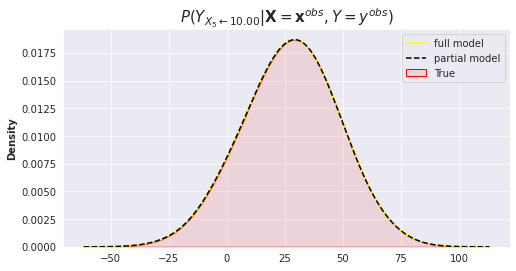

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

data={'Y':Y,'partial':SCM_partial_counterfactuals['Y'],'full':SCM_counterfactuals['Y']}
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(data['Y'], ax=ax, color='red', fill=True,bw_adjust=2,legend=True,label='True',alpha=0.1)
sns.kdeplot(data['full'], ax=ax, color='yellow',linestyle='-' ,fill=False,bw_adjust=2,legend=True,label='full model')
sns.kdeplot(data['partial'], ax=ax,color='black',linestyle='--' ,fill=False,bw_adjust=2,legend=True,label='partial model')
plt.legend()
plt.ylabel('Density',fontweight='bold')
plt.title(r'$P(Y_{X_{5}\leftarrow %.2f}|\mathbf{X}=\mathbf{x}^{obs},Y=y^{obs})$'%j,fontsize=15)
fig.savefig('toy_model.pdf',format='pdf',dpi=600)


## Error Analysis

In [29]:
np.random.seed(11)
intervention_set=np.random.uniform(-10,10,100)
error_full=[]
error_partial=[]

for j in intervention_set:
    intervention='do(X5='+str(j)+')'
    SCM_counterfactuals=do_inference(scm,intervention)
    SCM_partial_counterfactuals=do_inference(scm_partial,intervention)
    
    X_6, X_5, X_4, X_3, X_2, X_1, Y= SCM(True,j)
    
    error_full.append( np.linalg.norm(Y-SCM_counterfactuals['Y'])/sample_size)
    error_partial.append(np.linalg.norm( Y-SCM_partial_counterfactuals['Y'])/sample_size)
    
    

==> started preprocessing data ...
==> finished preprocessing data ...
logs/ConditionalSCM/flow_best.pth.tar
==> Best LogProb: -12.209026

intervention------ do(X5=-6.394606222464616)
Inference: [0/1000 (0.0%)]	Intervention: do(X5=-6.394606222464616)
 Time taken: 6.93 secs
==> started preprocessing data ...
==> finished preprocessing data ...
logs/ConditionalSCM_partial/flow_best.pth.tar
==> Best LogProb: -10.126798

intervention------ do(X5=-6.394606222464616)
Inference: [0/1000 (0.0%)]	Intervention: do(X5=-6.394606222464616)
 Time taken: 4.45 secs
==> started preprocessing data ...
==> finished preprocessing data ...
logs/ConditionalSCM/flow_best.pth.tar
==> Best LogProb: -12.209026

intervention------ do(X5=-9.610495170247509)
Inference: [0/1000 (0.0%)]	Intervention: do(X5=-9.610495170247509)
 Time taken: 6.92 secs
==> started preprocessing data ...
==> finished preprocessing data ...
logs/ConditionalSCM_partial/flow_best.pth.tar
==> Best LogProb: -10.126798

intervention------ do(X

In [30]:
data=pd.DataFrame({'intervention':intervention_set,'error_partial':error_partial,'error_full': error_full})


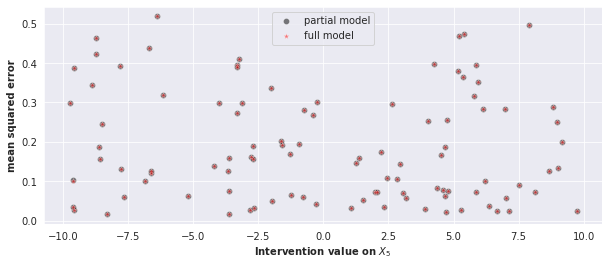

In [31]:

from matplotlib import pyplot as plt
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 4))
#plt.scatter(intervention_set,np.exp(np.array(error_partial)),label='partial model',color='black',ls='-',marker='o')
#plt.scatter(intervention_set,np.exp(np.array(error_full)),label='full model',color='yellow',ls='--',marker='*')
sns.scatterplot(data=data,x='intervention',y='error_partial',label='partial model',color='black',marker='o',alpha=0.5)
sns.scatterplot(data=data,x='intervention',y='error_full',label='full model',color='red',marker='*',alpha=0.5)

plt.xlabel(r'Intervention value on $X_{5}$ ',fontweight='bold')
plt.ylabel('mean squared error',fontweight='bold')
plt.legend()
fig.savefig('error_synthetic_data.pdf',format='pdf',dpi=1200)